In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR


from config import VitConfig
from model import VisionTransformer

In [2]:
import importlib
import model, config
importlib.reload(config)
importlib.reload(model)

from config import VitConfig
from model import VisionTransformer


In [3]:
config = VitConfig()
model = VisionTransformer(config)

In [4]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((config.img_size,config.img_size))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Create DataLoader for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Images shape: torch.Size([64, 3, 256, 256])
Labels shape: torch.Size([64])
dog
tensor([[[0.5216, 0.5216, 0.5216,  ..., 0.6510, 0.6510, 0.6510],
         [0.5216, 0.5216, 0.5216,  ..., 0.6510, 0.6510, 0.6510],
         [0.5216, 0.5216, 0.5216,  ..., 0.6510, 0.6510, 0.6510],
         ...,
         [0.5922, 0.5922, 0.5922,  ..., 0.6549, 0.6549, 0.6549],
         [0.5922, 0.5922, 0.5922,  ..., 0.6549, 0.6549, 0.6549],
         [0.5922, 0.5922, 0.5922,  ..., 0.6549, 0.6549, 0.6549]],

        [[0.3804, 0.3804, 0.3804,  ..., 0.6549, 0.6549, 0.6549],
         [0.3804, 0.3804, 0.3804,  ..., 0.6549, 0.6549, 0.6549],
         [0.3804, 0.3804, 0.3804,  ..., 0.6549, 0.6549, 0.6549],
         ...,
         [0.4549, 0.4549, 0.4549,  ..., 0.6118, 0.6118, 0.6118],
         [0.4549, 0.4549, 0.4549,  ..., 0.6118, 0.6118, 0.6118],
         [0.4549, 0.4549, 0.4549,  ..., 0.6118, 0.6118, 0.6118]],

        [[0.2510, 0.2510, 0.2510,  ..., 0.6353, 0.6353, 0.6353],
         [0.2510, 0.2510, 0.2510,  ..., 0.63

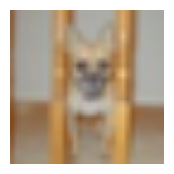

In [6]:
#CIFAR labels to human readable labels
CIFAR10_CLASSES = [
    'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]
data = next(iter(train_loader))
images, labels = data

# Check the shape of the images and labels
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

#decode the first image

def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(2, 2))  # keep this small to avoid blur
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')  # no interpolation
    plt.axis('off')
    plt.show()
print(CIFAR10_CLASSES[labels[0].item()])
print(images[0])
imshow(images[0])

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
num_epochs = 50
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs * len(train_loader), eta_min=1e-6)
print(device)


cuda


In [8]:
def train_epoch():
    model.train()
    total_loss = 0.0
    iter = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        print(f"Training Batch [{iter + 1}/{len(train_loader)}]: Loss {loss.item()}")
        iter += 1
    return total_loss / len(train_loader)

In [ ]:
for epoch in range(num_epochs):
    print(f"*********  Epoch {epoch + 1}/{num_epochs}  *********")
    train_loss = train_epoch()
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}")
    torch.save(model.state_dict(), "checkpoint.pth")

*********  Epoch 1/50  *********


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 2.6427671909332275
Training Batch [2/782]: Loss 6.912985801696777
Training Batch [3/782]: Loss 10.611411094665527
Training Batch [4/782]: Loss 13.058053970336914
Training Batch [5/782]: Loss 14.403803825378418
Training Batch [6/782]: Loss 11.83556842803955
Training Batch [7/782]: Loss 11.036925315856934
Training Batch [8/782]: Loss 8.7177095413208
Training Batch [9/782]: Loss 7.986027717590332
Training Batch [10/782]: Loss 8.994300842285156
Training Batch [11/782]: Loss 8.163991928100586
Training Batch [12/782]: Loss 7.805727958679199
Training Batch [13/782]: Loss 4.646242618560791
Training Batch [14/782]: Loss 5.380176067352295
Training Batch [15/782]: Loss 6.1363959312438965
Training Batch [16/782]: Loss 5.505861282348633
Training Batch [17/782]: Loss 4.980743408203125
Training Batch [18/782]: Loss 3.9210944175720215
Training Batch [19/782]: Loss 3.5745840072631836
Training Batch [20/782]: Loss 3.1288793087005615
Training Batch [21/782]: Loss 3.6535227298

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 1.669311285018921
Training Batch [2/782]: Loss 1.771156907081604
Training Batch [3/782]: Loss 1.334567904472351
Training Batch [4/782]: Loss 1.4419646263122559
Training Batch [5/782]: Loss 1.5927104949951172
Training Batch [6/782]: Loss 1.6542266607284546
Training Batch [7/782]: Loss 1.6458332538604736
Training Batch [8/782]: Loss 1.6179670095443726
Training Batch [9/782]: Loss 1.4127362966537476
Training Batch [10/782]: Loss 1.6375575065612793
Training Batch [11/782]: Loss 1.48954176902771
Training Batch [12/782]: Loss 1.554593563079834
Training Batch [13/782]: Loss 1.5206186771392822
Training Batch [14/782]: Loss 1.9191505908966064
Training Batch [15/782]: Loss 1.3482847213745117
Training Batch [16/782]: Loss 1.5136271715164185
Training Batch [17/782]: Loss 1.3815851211547852
Training Batch [18/782]: Loss 1.6507635116577148
Training Batch [19/782]: Loss 1.4106513261795044
Training Batch [20/782]: Loss 1.5780584812164307
Training Batch [21/782]: Loss 1.523

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 1.3507921695709229
Training Batch [2/782]: Loss 1.476370930671692
Training Batch [3/782]: Loss 1.3606863021850586
Training Batch [4/782]: Loss 1.4710832834243774
Training Batch [5/782]: Loss 1.3527103662490845
Training Batch [6/782]: Loss 1.3261009454727173
Training Batch [7/782]: Loss 1.312835454940796
Training Batch [8/782]: Loss 1.3032159805297852
Training Batch [9/782]: Loss 1.3501642942428589
Training Batch [10/782]: Loss 1.3428913354873657
Training Batch [11/782]: Loss 1.1251834630966187
Training Batch [12/782]: Loss 1.1766877174377441
Training Batch [13/782]: Loss 1.5204981565475464
Training Batch [14/782]: Loss 1.1831659078598022
Training Batch [15/782]: Loss 1.2182105779647827
Training Batch [16/782]: Loss 1.1544897556304932
Training Batch [17/782]: Loss 1.3017206192016602
Training Batch [18/782]: Loss 1.165776014328003
Training Batch [19/782]: Loss 1.3892936706542969
Training Batch [20/782]: Loss 1.3149158954620361
Training Batch [21/782]: Loss 1.

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 1.1561529636383057
Training Batch [2/782]: Loss 1.0931406021118164
Training Batch [3/782]: Loss 1.4568461179733276
Training Batch [4/782]: Loss 1.2978914976119995
Training Batch [5/782]: Loss 1.0057791471481323
Training Batch [6/782]: Loss 1.2686883211135864
Training Batch [7/782]: Loss 0.9160135984420776
Training Batch [8/782]: Loss 1.4593256711959839
Training Batch [9/782]: Loss 0.9919157028198242
Training Batch [10/782]: Loss 0.9837603569030762
Training Batch [11/782]: Loss 1.1561076641082764
Training Batch [12/782]: Loss 1.4466747045516968
Training Batch [13/782]: Loss 1.1446185111999512
Training Batch [14/782]: Loss 0.9964779615402222
Training Batch [15/782]: Loss 0.9481492638587952
Training Batch [16/782]: Loss 1.2090100049972534
Training Batch [17/782]: Loss 1.3957868814468384
Training Batch [18/782]: Loss 1.4167758226394653
Training Batch [19/782]: Loss 1.1294256448745728
Training Batch [20/782]: Loss 1.0301140546798706
Training Batch [21/782]: Loss

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.86085045337677
Training Batch [2/782]: Loss 0.9971923232078552
Training Batch [3/782]: Loss 0.9103062152862549
Training Batch [4/782]: Loss 0.896773099899292
Training Batch [5/782]: Loss 0.9750640392303467
Training Batch [6/782]: Loss 1.2752254009246826
Training Batch [7/782]: Loss 1.0048805475234985
Training Batch [8/782]: Loss 0.827017605304718
Training Batch [9/782]: Loss 0.9521006345748901
Training Batch [10/782]: Loss 0.9269885420799255
Training Batch [11/782]: Loss 0.9615671038627625
Training Batch [12/782]: Loss 0.9071106910705566
Training Batch [13/782]: Loss 1.0126230716705322
Training Batch [14/782]: Loss 0.9281578660011292
Training Batch [15/782]: Loss 0.9500395059585571
Training Batch [16/782]: Loss 0.9941131472587585
Training Batch [17/782]: Loss 1.0426025390625
Training Batch [18/782]: Loss 0.8729043006896973
Training Batch [19/782]: Loss 0.7761616706848145
Training Batch [20/782]: Loss 0.8410122394561768
Training Batch [21/782]: Loss 0.8730

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.9212702512741089
Training Batch [2/782]: Loss 0.6790826320648193
Training Batch [3/782]: Loss 0.8891717195510864
Training Batch [4/782]: Loss 0.7957009673118591
Training Batch [5/782]: Loss 0.7205362319946289
Training Batch [6/782]: Loss 0.6673457622528076
Training Batch [7/782]: Loss 0.6240573525428772
Training Batch [8/782]: Loss 0.6749611496925354
Training Batch [9/782]: Loss 0.7992047667503357
Training Batch [10/782]: Loss 1.0011423826217651
Training Batch [11/782]: Loss 0.70534348487854
Training Batch [12/782]: Loss 0.6683110594749451
Training Batch [13/782]: Loss 0.8855049014091492
Training Batch [14/782]: Loss 0.8454811573028564
Training Batch [15/782]: Loss 0.7013623714447021
Training Batch [16/782]: Loss 0.6714210510253906
Training Batch [17/782]: Loss 0.6593284606933594
Training Batch [18/782]: Loss 0.6465762257575989
Training Batch [19/782]: Loss 0.7726589441299438
Training Batch [20/782]: Loss 0.7548289895057678
Training Batch [21/782]: Loss 0

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.6933326721191406
Training Batch [2/782]: Loss 0.5644760727882385
Training Batch [3/782]: Loss 0.5489718914031982
Training Batch [4/782]: Loss 0.5565447211265564
Training Batch [5/782]: Loss 0.5556743144989014
Training Batch [6/782]: Loss 0.5935924053192139
Training Batch [7/782]: Loss 0.5282039642333984
Training Batch [8/782]: Loss 0.70393306016922
Training Batch [9/782]: Loss 0.4386971890926361
Training Batch [10/782]: Loss 0.4922192394733429
Training Batch [11/782]: Loss 0.5751290917396545
Training Batch [12/782]: Loss 0.5034543871879578
Training Batch [13/782]: Loss 0.44199231266975403
Training Batch [14/782]: Loss 0.4690139889717102
Training Batch [15/782]: Loss 0.4883616268634796
Training Batch [16/782]: Loss 0.5073044300079346
Training Batch [17/782]: Loss 0.5322139859199524
Training Batch [18/782]: Loss 0.7037750482559204
Training Batch [19/782]: Loss 0.43537837266921997
Training Batch [20/782]: Loss 0.42309287190437317
Training Batch [21/782]: Los

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.3888770341873169
Training Batch [2/782]: Loss 0.3780551254749298
Training Batch [3/782]: Loss 0.32549288868904114
Training Batch [4/782]: Loss 0.35650989413261414
Training Batch [5/782]: Loss 0.2742386758327484
Training Batch [6/782]: Loss 0.3521635830402374
Training Batch [7/782]: Loss 0.31611740589141846
Training Batch [8/782]: Loss 0.46598124504089355
Training Batch [9/782]: Loss 0.2293248027563095
Training Batch [10/782]: Loss 0.22848905622959137
Training Batch [11/782]: Loss 0.2941232919692993
Training Batch [12/782]: Loss 0.45411354303359985
Training Batch [13/782]: Loss 0.2710525393486023
Training Batch [14/782]: Loss 0.40785959362983704
Training Batch [15/782]: Loss 0.28833386301994324
Training Batch [16/782]: Loss 0.3556647002696991
Training Batch [17/782]: Loss 0.37524110078811646
Training Batch [18/782]: Loss 0.2588706314563751
Training Batch [19/782]: Loss 0.35034671425819397
Training Batch [20/782]: Loss 0.3325197994709015
Training Batch [21/

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.2580684423446655
Training Batch [2/782]: Loss 0.22649222612380981
Training Batch [3/782]: Loss 0.21889297664165497
Training Batch [4/782]: Loss 0.08862173557281494
Training Batch [5/782]: Loss 0.3013336658477783
Training Batch [6/782]: Loss 0.2594263553619385
Training Batch [7/782]: Loss 0.2108449786901474
Training Batch [8/782]: Loss 0.23601190745830536
Training Batch [9/782]: Loss 0.26226580142974854
Training Batch [10/782]: Loss 0.13616134226322174
Training Batch [11/782]: Loss 0.20891638100147247
Training Batch [12/782]: Loss 0.28534018993377686
Training Batch [13/782]: Loss 0.1896534413099289
Training Batch [14/782]: Loss 0.24473443627357483
Training Batch [15/782]: Loss 0.2521587014198303
Training Batch [16/782]: Loss 0.27980977296829224
Training Batch [17/782]: Loss 0.11889413744211197
Training Batch [18/782]: Loss 0.2879861295223236
Training Batch [19/782]: Loss 0.16926459968090057
Training Batch [20/782]: Loss 0.14066125452518463
Training Batch [

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.14455266296863556
Training Batch [2/782]: Loss 0.22968460619449615
Training Batch [3/782]: Loss 0.2775844931602478
Training Batch [4/782]: Loss 0.16728192567825317
Training Batch [5/782]: Loss 0.18872641026973724
Training Batch [6/782]: Loss 0.3518689274787903
Training Batch [7/782]: Loss 0.15881818532943726
Training Batch [8/782]: Loss 0.1082465648651123
Training Batch [9/782]: Loss 0.1427977830171585
Training Batch [10/782]: Loss 0.17939862608909607
Training Batch [11/782]: Loss 0.18351204693317413
Training Batch [12/782]: Loss 0.12560150027275085
Training Batch [13/782]: Loss 0.2880468964576721
Training Batch [14/782]: Loss 0.21281898021697998
Training Batch [15/782]: Loss 0.15562893450260162
Training Batch [16/782]: Loss 0.13997882604599
Training Batch [17/782]: Loss 0.2650398015975952
Training Batch [18/782]: Loss 0.2743776738643646
Training Batch [19/782]: Loss 0.3021382987499237
Training Batch [20/782]: Loss 0.23222041130065918
Training Batch [21/7

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.043554846197366714
Training Batch [2/782]: Loss 0.030814532190561295
Training Batch [3/782]: Loss 0.07860065996646881
Training Batch [4/782]: Loss 0.18500584363937378
Training Batch [5/782]: Loss 0.08874477446079254
Training Batch [6/782]: Loss 0.08258090168237686
Training Batch [7/782]: Loss 0.04602144658565521
Training Batch [8/782]: Loss 0.0513836033642292
Training Batch [9/782]: Loss 0.19135676324367523
Training Batch [10/782]: Loss 0.13076087832450867
Training Batch [11/782]: Loss 0.06902613490819931
Training Batch [12/782]: Loss 0.08911758661270142
Training Batch [13/782]: Loss 0.08191109448671341
Training Batch [14/782]: Loss 0.1109248697757721
Training Batch [15/782]: Loss 0.14542634785175323
Training Batch [16/782]: Loss 0.14650900661945343
Training Batch [17/782]: Loss 0.13903333246707916
Training Batch [18/782]: Loss 0.05074549466371536
Training Batch [19/782]: Loss 0.027035975828766823
Training Batch [20/782]: Loss 0.07263390719890594
Training

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.06832349300384521
Training Batch [2/782]: Loss 0.06892449408769608
Training Batch [3/782]: Loss 0.042390551418066025
Training Batch [4/782]: Loss 0.09605948626995087
Training Batch [5/782]: Loss 0.09851905703544617
Training Batch [6/782]: Loss 0.09339132905006409
Training Batch [7/782]: Loss 0.06153939291834831
Training Batch [8/782]: Loss 0.031825147569179535
Training Batch [9/782]: Loss 0.17220863699913025
Training Batch [10/782]: Loss 0.07596659660339355
Training Batch [11/782]: Loss 0.08619154989719391
Training Batch [12/782]: Loss 0.2024409919977188
Training Batch [13/782]: Loss 0.1291334629058838
Training Batch [14/782]: Loss 0.04119311645627022
Training Batch [15/782]: Loss 0.06841946393251419
Training Batch [16/782]: Loss 0.12631110846996307
Training Batch [17/782]: Loss 0.10545986145734787
Training Batch [18/782]: Loss 0.13405443727970123
Training Batch [19/782]: Loss 0.20501422882080078
Training Batch [20/782]: Loss 0.12265895307064056
Training 

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.062008000910282135
Training Batch [2/782]: Loss 0.08718258887529373
Training Batch [3/782]: Loss 0.06389284133911133
Training Batch [4/782]: Loss 0.12732961773872375
Training Batch [5/782]: Loss 0.28981688618659973
Training Batch [6/782]: Loss 0.052181605249643326
Training Batch [7/782]: Loss 0.013982804492115974
Training Batch [8/782]: Loss 0.09944828599691391
Training Batch [9/782]: Loss 0.09627041965723038
Training Batch [10/782]: Loss 0.07917682081460953
Training Batch [11/782]: Loss 0.08774713426828384
Training Batch [12/782]: Loss 0.07776996493339539
Training Batch [13/782]: Loss 0.13399094343185425
Training Batch [14/782]: Loss 0.108158178627491
Training Batch [15/782]: Loss 0.026395605877041817
Training Batch [16/782]: Loss 0.034544553607702255
Training Batch [17/782]: Loss 0.09811799228191376
Training Batch [18/782]: Loss 0.03698507696390152
Training Batch [19/782]: Loss 0.11251324415206909
Training Batch [20/782]: Loss 0.06751641631126404
Traini

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.14592775702476501
Training Batch [2/782]: Loss 0.25831320881843567
Training Batch [3/782]: Loss 0.06616552919149399
Training Batch [4/782]: Loss 0.1134720966219902
Training Batch [5/782]: Loss 0.020713452249765396
Training Batch [6/782]: Loss 0.13476955890655518
Training Batch [7/782]: Loss 0.1343328058719635
Training Batch [8/782]: Loss 0.1792917400598526
Training Batch [9/782]: Loss 0.08746813237667084
Training Batch [10/782]: Loss 0.0973295196890831
Training Batch [11/782]: Loss 0.11680733412504196
Training Batch [12/782]: Loss 0.1701159030199051
Training Batch [13/782]: Loss 0.11457806825637817
Training Batch [14/782]: Loss 0.19185738265514374
Training Batch [15/782]: Loss 0.09391165524721146
Training Batch [16/782]: Loss 0.12388303875923157
Training Batch [17/782]: Loss 0.2185559868812561
Training Batch [18/782]: Loss 0.07617458701133728
Training Batch [19/782]: Loss 0.20622961223125458
Training Batch [20/782]: Loss 0.04595644399523735
Training Batch

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.048462145030498505
Training Batch [2/782]: Loss 0.026910103857517242
Training Batch [3/782]: Loss 0.03526182472705841
Training Batch [4/782]: Loss 0.13899844884872437
Training Batch [5/782]: Loss 0.08609139174222946
Training Batch [6/782]: Loss 0.10820578038692474
Training Batch [7/782]: Loss 0.09539537876844406
Training Batch [8/782]: Loss 0.0826115608215332
Training Batch [9/782]: Loss 0.14141598343849182
Training Batch [10/782]: Loss 0.09001895785331726
Training Batch [11/782]: Loss 0.14099764823913574
Training Batch [12/782]: Loss 0.006143782753497362
Training Batch [13/782]: Loss 0.020087813958525658
Training Batch [14/782]: Loss 0.1253228336572647
Training Batch [15/782]: Loss 0.009045001119375229
Training Batch [16/782]: Loss 0.015390899032354355
Training Batch [17/782]: Loss 0.029146643355488777
Training Batch [18/782]: Loss 0.051617223769426346
Training Batch [19/782]: Loss 0.14802716672420502
Training Batch [20/782]: Loss 0.18559516966342926
Tra

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.026016496121883392
Training Batch [2/782]: Loss 0.025843417271971703
Training Batch [3/782]: Loss 0.022559313103556633
Training Batch [4/782]: Loss 0.08683820813894272
Training Batch [5/782]: Loss 0.04084640368819237
Training Batch [6/782]: Loss 0.04606059566140175
Training Batch [7/782]: Loss 0.03218395262956619
Training Batch [8/782]: Loss 0.04021962359547615
Training Batch [9/782]: Loss 0.029377799481153488
Training Batch [10/782]: Loss 0.16171202063560486
Training Batch [11/782]: Loss 0.0726771429181099
Training Batch [12/782]: Loss 0.10993331670761108
Training Batch [13/782]: Loss 0.03533262386918068
Training Batch [14/782]: Loss 0.039185065776109695
Training Batch [15/782]: Loss 0.05005589872598648
Training Batch [16/782]: Loss 0.04140431433916092
Training Batch [17/782]: Loss 0.05061326175928116
Training Batch [18/782]: Loss 0.02284315973520279
Training Batch [19/782]: Loss 0.02980084717273712
Training Batch [20/782]: Loss 0.045019473880529404
Trai

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.04507816582918167
Training Batch [2/782]: Loss 0.1355670541524887
Training Batch [3/782]: Loss 0.028395622968673706
Training Batch [4/782]: Loss 0.05525147542357445
Training Batch [5/782]: Loss 0.03458457812666893
Training Batch [6/782]: Loss 0.04737276956439018
Training Batch [7/782]: Loss 0.09915130585432053
Training Batch [8/782]: Loss 0.043087590485811234
Training Batch [9/782]: Loss 0.17660145461559296
Training Batch [10/782]: Loss 0.1031300276517868
Training Batch [11/782]: Loss 0.0034771952778100967
Training Batch [12/782]: Loss 0.0388760082423687
Training Batch [13/782]: Loss 0.17106685042381287
Training Batch [14/782]: Loss 0.09711470454931259
Training Batch [15/782]: Loss 0.03943207487463951
Training Batch [16/782]: Loss 0.06272899359464645
Training Batch [17/782]: Loss 0.008329429663717747
Training Batch [18/782]: Loss 0.08214032649993896
Training Batch [19/782]: Loss 0.03794296458363533
Training Batch [20/782]: Loss 0.07594463229179382
Trainin

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.017394397407770157
Training Batch [2/782]: Loss 0.03942537307739258
Training Batch [3/782]: Loss 0.04941323772072792
Training Batch [4/782]: Loss 0.009529132395982742
Training Batch [5/782]: Loss 0.022444628179073334
Training Batch [6/782]: Loss 0.05379017814993858
Training Batch [7/782]: Loss 0.03171065077185631
Training Batch [8/782]: Loss 0.08033395558595657
Training Batch [9/782]: Loss 0.008929365314543247
Training Batch [10/782]: Loss 0.04145905375480652
Training Batch [11/782]: Loss 0.015186850912868977
Training Batch [12/782]: Loss 0.02481311559677124
Training Batch [13/782]: Loss 0.059732623398303986
Training Batch [14/782]: Loss 0.018348241224884987
Training Batch [15/782]: Loss 0.06434718519449234
Training Batch [16/782]: Loss 0.004720725584775209
Training Batch [17/782]: Loss 0.0021509367506951094
Training Batch [18/782]: Loss 0.009903422556817532
Training Batch [19/782]: Loss 0.0626746192574501
Training Batch [20/782]: Loss 0.01553222350776195

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.012963948771357536
Training Batch [2/782]: Loss 0.06613315641880035
Training Batch [3/782]: Loss 0.13085614144802094
Training Batch [4/782]: Loss 0.013277006335556507
Training Batch [5/782]: Loss 0.012540053576231003
Training Batch [6/782]: Loss 0.007976170629262924
Training Batch [7/782]: Loss 0.06386247277259827
Training Batch [8/782]: Loss 0.13600537180900574
Training Batch [9/782]: Loss 0.042025815695524216
Training Batch [10/782]: Loss 0.02142620086669922
Training Batch [11/782]: Loss 0.08096549659967422
Training Batch [12/782]: Loss 0.036962106823921204
Training Batch [13/782]: Loss 0.023336762562394142
Training Batch [14/782]: Loss 0.03938792645931244
Training Batch [15/782]: Loss 0.014525122940540314
Training Batch [16/782]: Loss 0.010337842628359795
Training Batch [17/782]: Loss 0.05611244961619377
Training Batch [18/782]: Loss 0.062295787036418915
Training Batch [19/782]: Loss 0.04204000160098076
Training Batch [20/782]: Loss 0.07097294181585312

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.02037859335541725
Training Batch [2/782]: Loss 0.033401183784008026
Training Batch [3/782]: Loss 0.10276190936565399
Training Batch [4/782]: Loss 0.046803299337625504
Training Batch [5/782]: Loss 0.04034430906176567
Training Batch [6/782]: Loss 0.046504780650138855
Training Batch [7/782]: Loss 0.018188796937465668
Training Batch [8/782]: Loss 0.031157031655311584
Training Batch [9/782]: Loss 0.0359649732708931
Training Batch [10/782]: Loss 0.008380351588129997
Training Batch [11/782]: Loss 0.11972301453351974
Training Batch [12/782]: Loss 0.05489032343029976
Training Batch [13/782]: Loss 0.03166890889406204
Training Batch [14/782]: Loss 0.04102039709687233
Training Batch [15/782]: Loss 0.15160919725894928
Training Batch [16/782]: Loss 0.018122857436537743
Training Batch [17/782]: Loss 0.08849532902240753
Training Batch [18/782]: Loss 0.05645535886287689
Training Batch [19/782]: Loss 0.06600691378116608
Training Batch [20/782]: Loss 0.052205536514520645
Tr

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.004473500419408083
Training Batch [2/782]: Loss 0.0410652831196785
Training Batch [3/782]: Loss 0.009227238595485687
Training Batch [4/782]: Loss 0.027002332732081413
Training Batch [5/782]: Loss 0.0029288125224411488
Training Batch [6/782]: Loss 0.0252080000936985
Training Batch [7/782]: Loss 0.01929357461631298
Training Batch [8/782]: Loss 0.011421866714954376
Training Batch [9/782]: Loss 0.07937122136354446
Training Batch [10/782]: Loss 0.03670114651322365
Training Batch [11/782]: Loss 0.09438450634479523
Training Batch [12/782]: Loss 0.0054612900130450726
Training Batch [13/782]: Loss 0.01893509365618229
Training Batch [14/782]: Loss 0.00989584717899561
Training Batch [15/782]: Loss 0.003585740691050887
Training Batch [16/782]: Loss 0.013565833680331707
Training Batch [17/782]: Loss 0.006182923447340727
Training Batch [18/782]: Loss 0.016750318929553032
Training Batch [19/782]: Loss 0.024472704157233238
Training Batch [20/782]: Loss 0.0258184708654880

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.00183367810677737
Training Batch [2/782]: Loss 0.07709392160177231
Training Batch [3/782]: Loss 0.048565302044153214
Training Batch [4/782]: Loss 0.060181643813848495
Training Batch [5/782]: Loss 0.11595075577497482
Training Batch [6/782]: Loss 0.03432484716176987
Training Batch [7/782]: Loss 0.021548563614487648
Training Batch [8/782]: Loss 0.01598474197089672
Training Batch [9/782]: Loss 0.0054685319773852825
Training Batch [10/782]: Loss 0.018182557076215744
Training Batch [11/782]: Loss 0.024511225521564484
Training Batch [12/782]: Loss 0.0036322695668786764
Training Batch [13/782]: Loss 0.05984019488096237
Training Batch [14/782]: Loss 0.00967406202107668
Training Batch [15/782]: Loss 0.03205100819468498
Training Batch [16/782]: Loss 0.041306909173727036
Training Batch [17/782]: Loss 0.04879220575094223
Training Batch [18/782]: Loss 0.007318316958844662
Training Batch [19/782]: Loss 0.005270066671073437
Training Batch [20/782]: Loss 0.004969984758645

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.0145140765234828
Training Batch [2/782]: Loss 0.0013894952135160565
Training Batch [3/782]: Loss 0.017292054370045662
Training Batch [4/782]: Loss 0.013316278345882893
Training Batch [5/782]: Loss 0.011312225833535194
Training Batch [6/782]: Loss 0.007698098197579384
Training Batch [7/782]: Loss 0.008922107517719269
Training Batch [8/782]: Loss 0.005012991838157177
Training Batch [9/782]: Loss 0.0010921551147475839
Training Batch [10/782]: Loss 0.010113932192325592
Training Batch [11/782]: Loss 0.007872013375163078
Training Batch [12/782]: Loss 0.01010710559785366
Training Batch [13/782]: Loss 0.001880443305708468
Training Batch [14/782]: Loss 0.00543553801253438
Training Batch [15/782]: Loss 0.010335858911275864
Training Batch [16/782]: Loss 0.037918370217084885
Training Batch [17/782]: Loss 0.008979527279734612
Training Batch [18/782]: Loss 0.047072261571884155
Training Batch [19/782]: Loss 0.021940261125564575
Training Batch [20/782]: Loss 0.0049083274

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.010740618221461773
Training Batch [2/782]: Loss 0.008239414542913437
Training Batch [3/782]: Loss 0.012857564724981785
Training Batch [4/782]: Loss 0.041625503450632095
Training Batch [5/782]: Loss 0.00942261517047882
Training Batch [6/782]: Loss 0.009045598097145557
Training Batch [7/782]: Loss 0.006548373959958553
Training Batch [8/782]: Loss 0.007540639024227858
Training Batch [9/782]: Loss 0.002324010245501995
Training Batch [10/782]: Loss 0.014732945710420609
Training Batch [11/782]: Loss 0.06335888057947159
Training Batch [12/782]: Loss 0.0007520922226831317
Training Batch [13/782]: Loss 0.010242531076073647
Training Batch [14/782]: Loss 0.03222712129354477
Training Batch [15/782]: Loss 0.01452160906046629
Training Batch [16/782]: Loss 0.007123912218958139
Training Batch [17/782]: Loss 0.019879499450325966
Training Batch [18/782]: Loss 0.04900846257805824
Training Batch [19/782]: Loss 0.007131134159862995
Training Batch [20/782]: Loss 0.097078919410

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.002505883574485779
Training Batch [2/782]: Loss 0.03664118051528931
Training Batch [3/782]: Loss 0.005122596397995949
Training Batch [4/782]: Loss 0.004466942977160215
Training Batch [5/782]: Loss 0.00396021967753768
Training Batch [6/782]: Loss 0.004210576880723238
Training Batch [7/782]: Loss 0.00026046097627840936
Training Batch [8/782]: Loss 0.0005286703235469759
Training Batch [9/782]: Loss 0.03241587430238724
Training Batch [10/782]: Loss 0.002946763299405575
Training Batch [11/782]: Loss 0.0022048125974833965
Training Batch [12/782]: Loss 0.008179845288395882
Training Batch [13/782]: Loss 0.0031548941042274237
Training Batch [14/782]: Loss 0.0397786870598793
Training Batch [15/782]: Loss 0.11070617288351059
Training Batch [16/782]: Loss 0.0018212248105555773
Training Batch [17/782]: Loss 0.014694703742861748
Training Batch [18/782]: Loss 0.07366973161697388
Training Batch [19/782]: Loss 0.07047471404075623
Training Batch [20/782]: Loss 0.0041611995

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.0017147427424788475
Training Batch [2/782]: Loss 0.015194966457784176
Training Batch [3/782]: Loss 0.04524771496653557
Training Batch [4/782]: Loss 0.009092356078326702
Training Batch [5/782]: Loss 0.00449894554913044
Training Batch [6/782]: Loss 0.2617761492729187
Training Batch [7/782]: Loss 0.017431208863854408
Training Batch [8/782]: Loss 0.08070462942123413
Training Batch [9/782]: Loss 0.012455705553293228
Training Batch [10/782]: Loss 0.003313937457278371
Training Batch [11/782]: Loss 0.004743857774883509
Training Batch [12/782]: Loss 0.03690560907125473
Training Batch [13/782]: Loss 0.023382507264614105
Training Batch [14/782]: Loss 0.008761873468756676
Training Batch [15/782]: Loss 0.04639717563986778
Training Batch [16/782]: Loss 0.006473974324762821
Training Batch [17/782]: Loss 0.00593446334823966
Training Batch [18/782]: Loss 0.05132071301341057
Training Batch [19/782]: Loss 0.004588640294969082
Training Batch [20/782]: Loss 0.0019382464233785

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.009050401858985424
Training Batch [2/782]: Loss 0.004281720612198114
Training Batch [3/782]: Loss 0.06998588889837265
Training Batch [4/782]: Loss 0.0016909007681533694
Training Batch [5/782]: Loss 0.00966891460120678
Training Batch [6/782]: Loss 0.02533368207514286
Training Batch [7/782]: Loss 0.003070921404287219
Training Batch [8/782]: Loss 0.0029401862993836403
Training Batch [9/782]: Loss 0.018476204946637154
Training Batch [10/782]: Loss 0.033717986196279526
Training Batch [11/782]: Loss 0.048357367515563965
Training Batch [12/782]: Loss 0.05992680788040161
Training Batch [13/782]: Loss 0.028163345530629158
Training Batch [14/782]: Loss 0.004584773909300566
Training Batch [15/782]: Loss 0.039503153413534164
Training Batch [16/782]: Loss 0.008015348576009274
Training Batch [17/782]: Loss 0.006289009936153889
Training Batch [18/782]: Loss 0.037035826593637466
Training Batch [19/782]: Loss 0.0020770507398992777
Training Batch [20/782]: Loss 0.062988005

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.0010653398931026459
Training Batch [2/782]: Loss 0.01104792207479477
Training Batch [3/782]: Loss 0.014087853953242302
Training Batch [4/782]: Loss 0.0010555455228313804
Training Batch [5/782]: Loss 0.0011020861566066742
Training Batch [6/782]: Loss 0.003167595248669386
Training Batch [7/782]: Loss 0.005397083703428507
Training Batch [8/782]: Loss 0.0010352787794545293
Training Batch [9/782]: Loss 0.02311541698873043
Training Batch [10/782]: Loss 0.0026215054094791412
Training Batch [11/782]: Loss 0.00017391357687301934
Training Batch [12/782]: Loss 0.015419566072523594
Training Batch [13/782]: Loss 0.03770488500595093
Training Batch [14/782]: Loss 0.0024008103646337986
Training Batch [15/782]: Loss 0.011180720292031765
Training Batch [16/782]: Loss 0.014141771011054516
Training Batch [17/782]: Loss 0.005595381837338209
Training Batch [18/782]: Loss 0.0022553603630512953
Training Batch [19/782]: Loss 0.057417213916778564
Training Batch [20/782]: Loss 0.01

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.00028605107218027115
Training Batch [2/782]: Loss 0.001671382924541831
Training Batch [3/782]: Loss 9.199480700772256e-05
Training Batch [4/782]: Loss 0.0030436324886977673
Training Batch [5/782]: Loss 0.0005812846357002854
Training Batch [6/782]: Loss 0.00011606252519413829
Training Batch [7/782]: Loss 0.0027613146230578423
Training Batch [8/782]: Loss 0.01201461162418127
Training Batch [9/782]: Loss 0.0005097264656797051
Training Batch [10/782]: Loss 0.008664306253194809
Training Batch [11/782]: Loss 0.0011645782506093383
Training Batch [12/782]: Loss 0.0009938833536580205
Training Batch [13/782]: Loss 0.006386094726622105
Training Batch [14/782]: Loss 0.0003485472407191992
Training Batch [15/782]: Loss 0.001765087596140802
Training Batch [16/782]: Loss 0.00529557466506958
Training Batch [17/782]: Loss 0.01329484861344099
Training Batch [18/782]: Loss 0.01658148691058159
Training Batch [19/782]: Loss 0.0018607518868520856
Training Batch [20/782]: Loss 0

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.00039006126462481916
Training Batch [2/782]: Loss 0.005476823076605797
Training Batch [3/782]: Loss 0.000591890187934041
Training Batch [4/782]: Loss 0.003741757245734334
Training Batch [5/782]: Loss 0.011143328621983528
Training Batch [6/782]: Loss 0.014513170346617699
Training Batch [7/782]: Loss 0.0013662552228197455
Training Batch [8/782]: Loss 0.00157981738448143
Training Batch [9/782]: Loss 0.0003905541088897735
Training Batch [10/782]: Loss 0.00040832889499142766
Training Batch [11/782]: Loss 0.0013560280203819275
Training Batch [12/782]: Loss 0.0010290774516761303
Training Batch [13/782]: Loss 0.008003600873053074
Training Batch [14/782]: Loss 0.005540838930755854
Training Batch [15/782]: Loss 0.012806903570890427
Training Batch [16/782]: Loss 0.00014310273400042206
Training Batch [17/782]: Loss 0.0032672835513949394
Training Batch [18/782]: Loss 0.0003531882830429822
Training Batch [19/782]: Loss 0.0006190675776451826
Training Batch [20/782]: Los

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Training Batch [1/782]: Loss 0.0019755023531615734
Training Batch [2/782]: Loss 0.001226123538799584
Training Batch [3/782]: Loss 0.0023182264994829893
Training Batch [4/782]: Loss 0.003525844542309642
Training Batch [5/782]: Loss 0.00010720214049797505
Training Batch [6/782]: Loss 0.0005947884055785835
Training Batch [7/782]: Loss 0.0010722620645537972
Training Batch [8/782]: Loss 0.0021413967479020357
Training Batch [9/782]: Loss 0.05060046166181564
Training Batch [10/782]: Loss 0.010898370295763016
Training Batch [11/782]: Loss 0.16629824042320251
Training Batch [12/782]: Loss 0.0005315057351253927
Training Batch [13/782]: Loss 0.04592514410614967
Training Batch [14/782]: Loss 0.04312952235341072
Training Batch [15/782]: Loss 0.03498021513223648
Training Batch [16/782]: Loss 0.04168299585580826
Training Batch [17/782]: Loss 0.0098885428160429
Training Batch [18/782]: Loss 0.019686169922351837
Training Batch [19/782]: Loss 0.0033759267535060644
Training Batch [20/782]: Loss 0.0642640

KeyboardInterrupt: 

In [2]:
#CIFAR labels to human readable labels
CIFAR10_CLASSES = [
    'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]
data = next(iter(test_loader))
images, labels = data

# Check the shape of the images and labels
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(2, 2))  # keep this small to avoid blur
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')  # no interpolation
    plt.axis('off')
    plt.show()

idx = 0
imshow(images[idx])

# images = images.to(device)
# y = model(images) # B, num_classes
# print(f"logits: {y[idx]}")
# pred = torch.nn.functional.softmax(y, dim=1) # B, num_classes
# print(f"probabilities: {pred[idx]}")
# pred = torch.argmax(pred, dim=1) # B
# print(f"predicted class: {pred[idx]}")

# print(f"label: {CIFAR10_CLASSES[labels[idx].item()]}")




NameError: name 'test_loader' is not defined